In [7]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import geopandas as gpd
import sampers
import mscthesis
import plotly.graph_objects as pgo
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import time
import validation

In [105]:
val = validation.Validator()
val.prepare_sampers()

Preparing scale national
Reading original data...
zones (682, 2)
odm (595984,) 221892.04955949992
Reindexing...
odm (465124,)
Calculating distances between zones...
distances (465124,)

Preparing scale east
Reading original data...
zones (3038, 5)
odm (9253764,) 4982573.000714299
Reindexing...
odm (9229444,)
Calculating distances between zones...
distances (9229444,)

Preparing scale west
Reading original data...
zones (2964, 5)
odm (8791225,) 3339597.621275899
Reindexing...
odm (8785296,)
Calculating distances between zones...
distances (8785296,)



# Sampers

In [26]:
sampers_scale = "east"

In [29]:
# Zones
sampers_zones = sampers.read_shp(sampers.shps[sampers_scale])

# ODM
sampers_odm = sampers.read_odm(sampers.odms[sampers_scale]).set_index(['ozone', 'dzone'])['total']

# Drop unknown zones (ie. trips between zones that are not part of shapefile)
# If ODM does not contain trips between regions they are set to 0.0
sampers_odm = sampers_odm.reindex(
    pd.MultiIndex.from_product([
        sampers_zones['zone'],
        sampers_zones['zone'],
    ]),
    fill_value=0.0,
)

# Normalize
sampers_odm = sampers_odm / sampers_odm.sum()

print("Sampers zones\t", sampers_zones.shape)
print("Sampers ODM\t", sampers_odm.shape)

Sampers zones	 (3038, 5)
Sampers ODM	 (9229444,)


In [30]:
# Distances between regions
sampers_zonesx = sampers_zones.set_index('zone')
distances = pairwise_distances(
    list(zip(
        sampers_zonesx.geometry.centroid.x.to_list(),
        sampers_zonesx.geometry.centroid.y.to_list(),
    ))
)
distancesx = pd.DataFrame(
    distances / 1000,
    columns=sampers_zonesx.index,
    index=sampers_zonesx.index,
).stack().reindex(sampers_odm.index)

print("Sampers distances\t", distancesx.shape)

Sampers distances	 (9229444,)


In [115]:
odm.to_csv('./h.csv')

In [118]:
f = open('./odm.npy', 'b')
np.save(f, odm.unstack().values)

TypeError: write() argument must be str, not bytes

# Visits

In [108]:
visits = pd.read_csv('./../../dbs/sweden/visits-song.csv').set_index('userid')
home_locations = pd.read_csv('./../../dbs/sweden/homelocations.csv').set_index('userid')
home_locations = gpd.GeoDataFrame(
    home_locations,
    crs="EPSG:3006",
    geometry=gpd.points_from_xy(home_locations.x, home_locations.y),
)
visits = val.prepare_visits(visits)

Converting visits to GeoDataFrame...
Converting CRS...


Scale = national
Not bboxing national
Aligning region-visits to Sampers zones...
removed 154224 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 12185 point-visits due to missing zone geom
1759991 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 970 iterations
0.6756027992873662
Scale = east
removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 1630 iterations
0.16682762521558958
Scale = west
removed 1563520 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 25844 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 2096 point-visits due to missing zone geom
334940 visits left after alignme

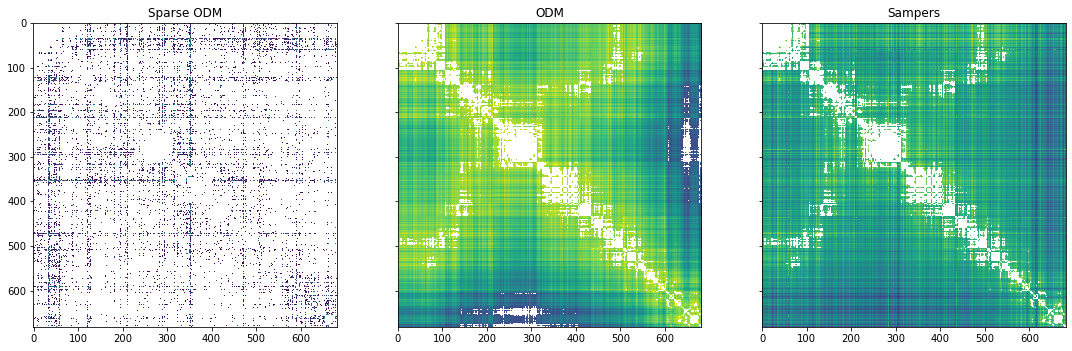

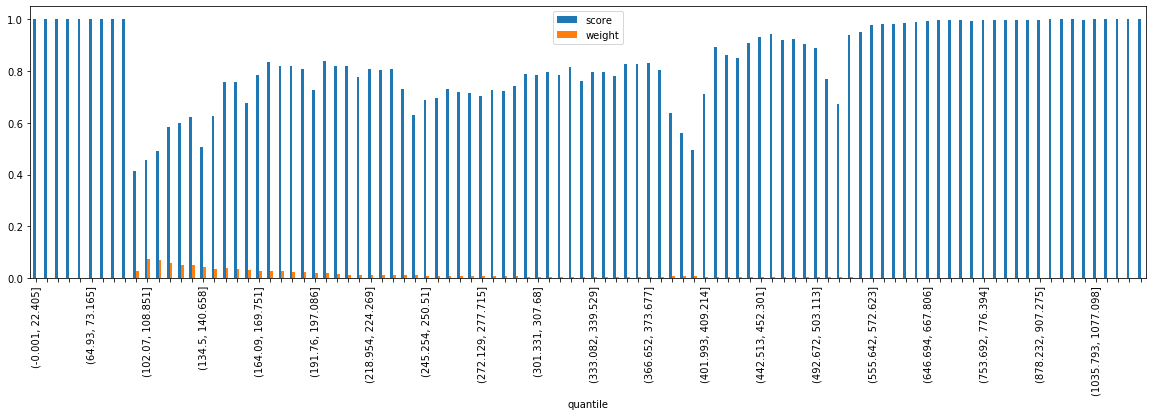

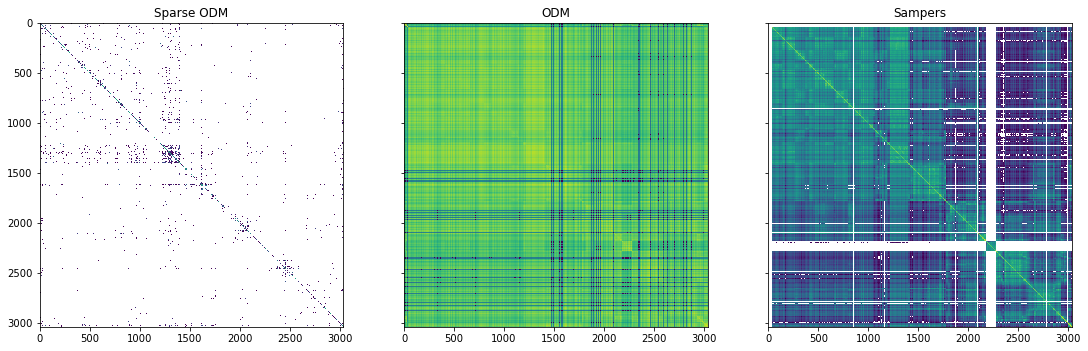

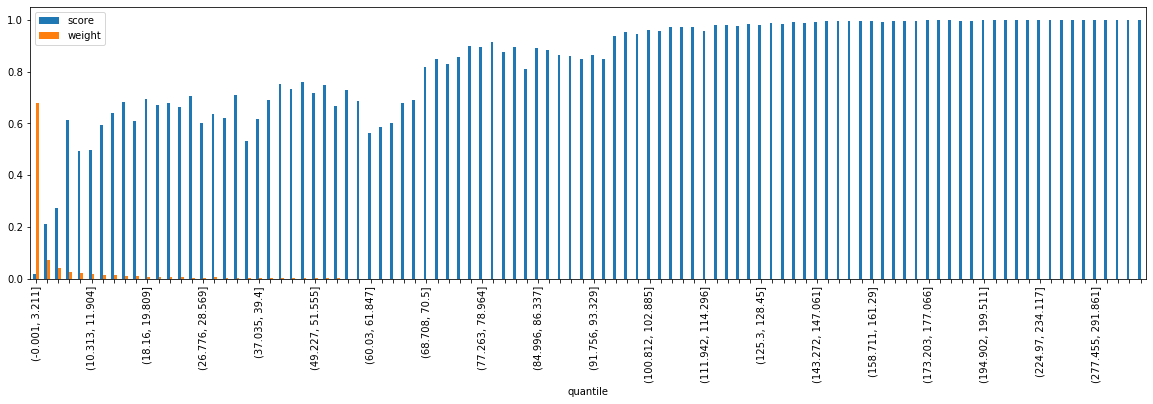

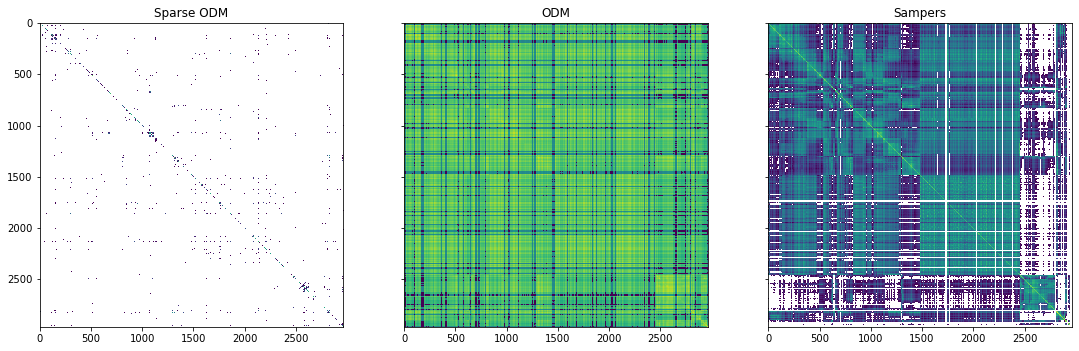

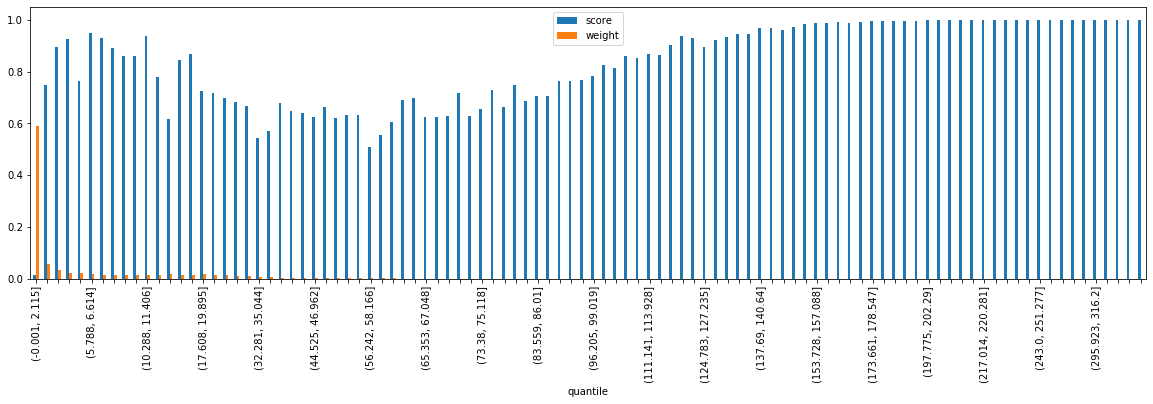

In [109]:
for scale in ['national', 'east', 'west']:
    print("Scale =", scale)
    odm, sparse_odm = val.validate(scale, visits, home_locations, gravity_beta=0.03)
    score = mscthesis.spssim(val.sampers_odm[scale], odm, val.sampers_distances[scale], nquantiles=100)
    validation_plots(odm, sparse_odm, val.sampers_odm[scale], score)
    print((score.score * score.weight).sum())
    print()

Scale = national
Not bboxing national
Aligning region-visits to Sampers zones...
removed 154224 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 12185 point-visits due to missing zone geom
1759991 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 400 iterations
0.7229209417966137

Scale = east
removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 480 iterations
0.15346678262022292

Scale = west
removed 1563520 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 25844 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 2096 point-visits due to missing zone geom
334940 visits left after alignm

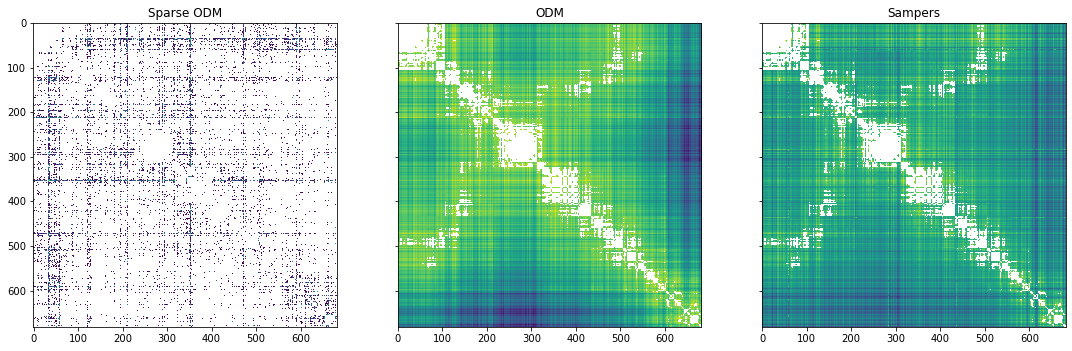

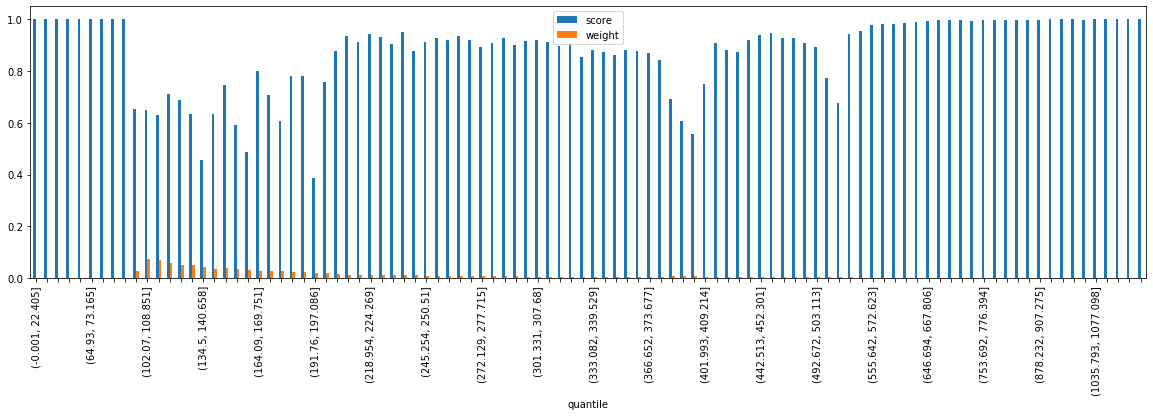

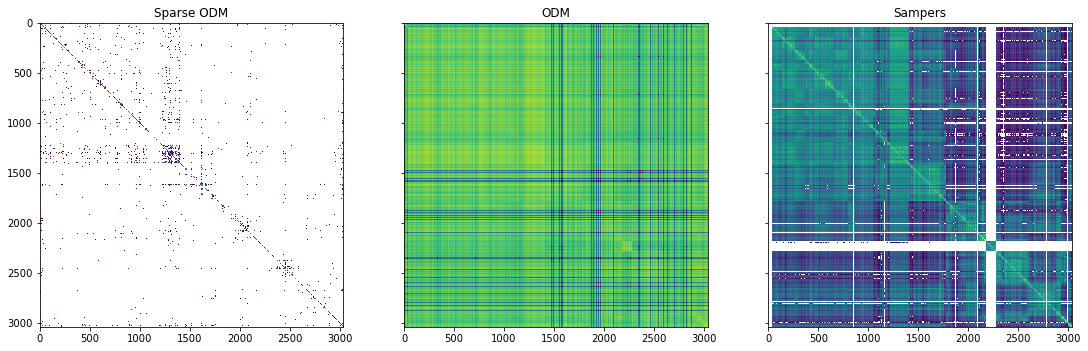

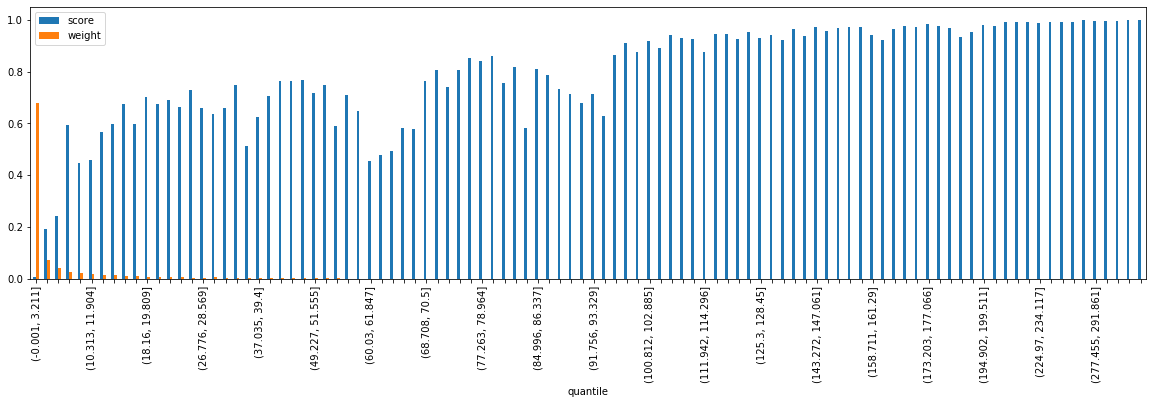

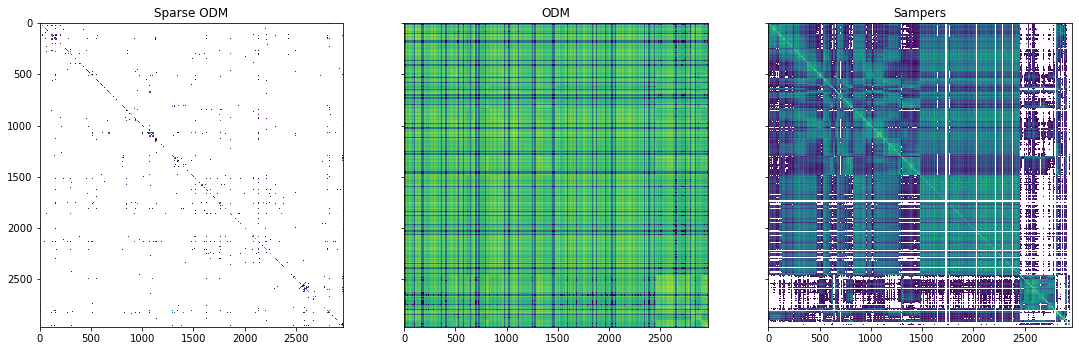

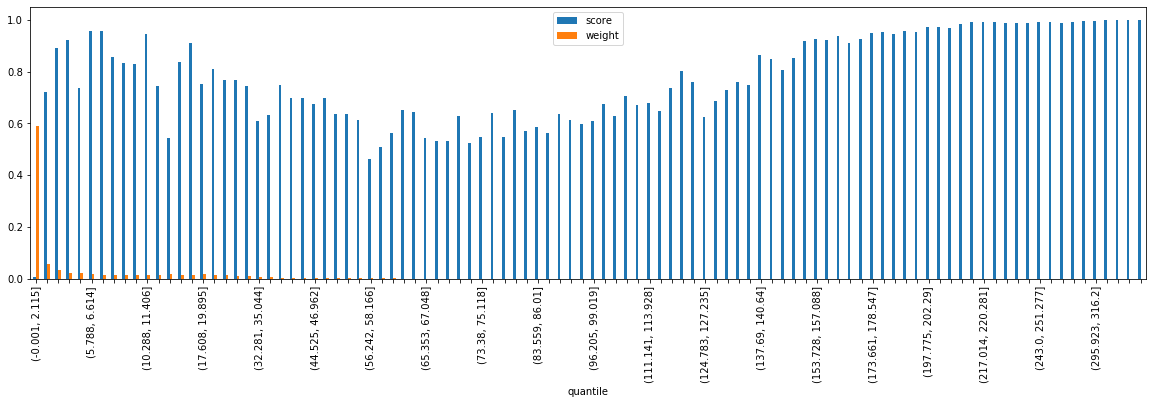

In [110]:
for scale in ['national', 'east', 'west']:
    print("Scale =", scale)
    odm, sparse_odm = val.validate(scale, visits, home_locations, gravity_beta=0.02)
    score = mscthesis.spssim(val.sampers_odm[scale], odm, val.sampers_distances[scale], nquantiles=100)
    validation_plots(odm, sparse_odm, val.sampers_odm[scale], score)
    print((score.score * score.weight).sum())
    print()

Scale = national
Not bboxing national
Aligning region-visits to Sampers zones...
removed 154224 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 12185 point-visits due to missing zone geom
1759991 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 2900 iterations
0.5627600027169182

Scale = east
removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...
Gravity model...
IPF did not converge with tolerance 1e-05 after 5000 iterations
0.18556134770097035

Scale = west
removed 1563520 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 25844 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 2096 point-visits due to missing zone geom
3

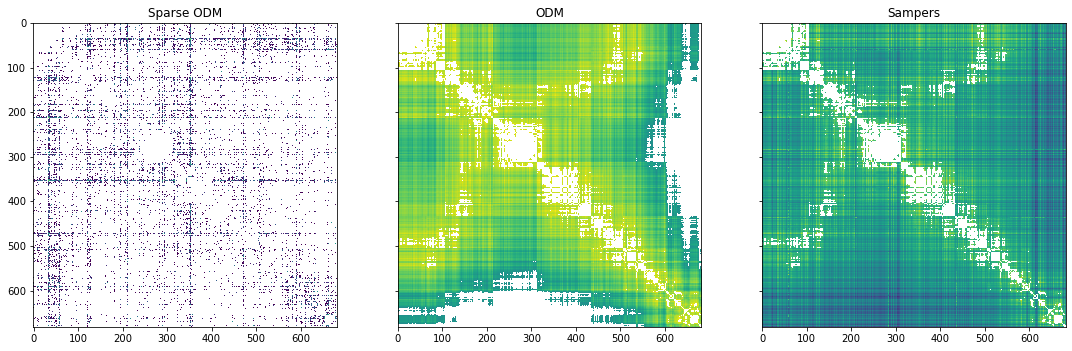

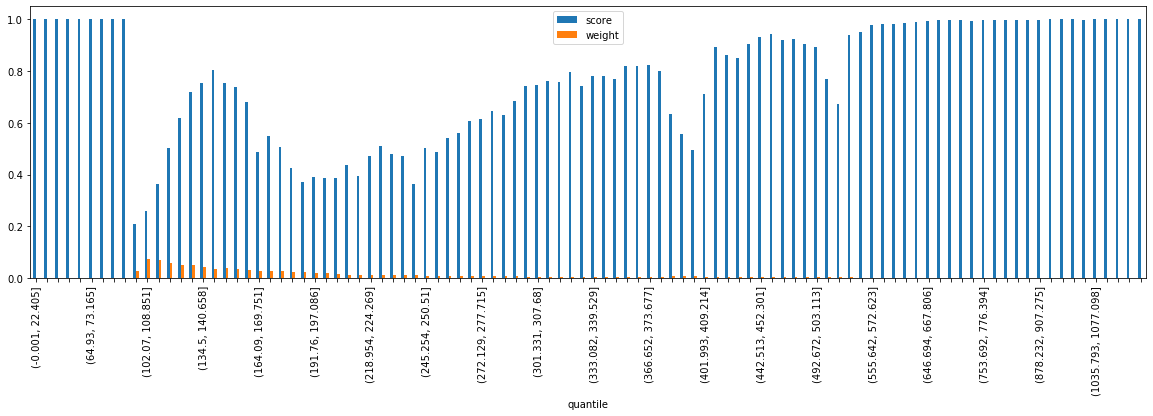

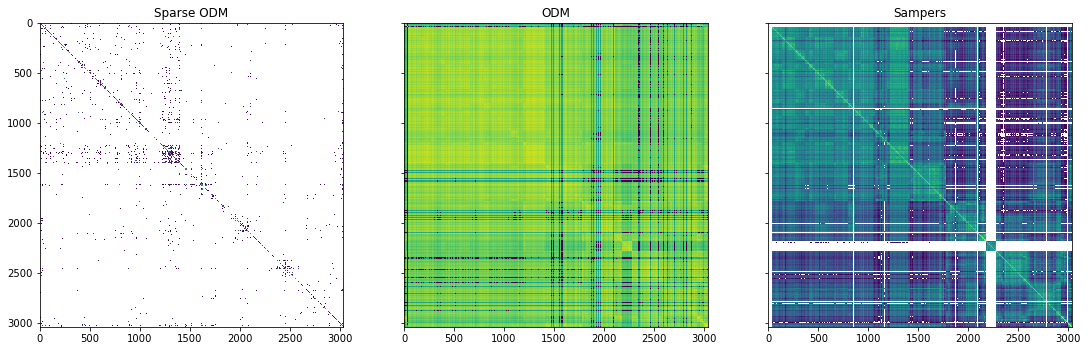

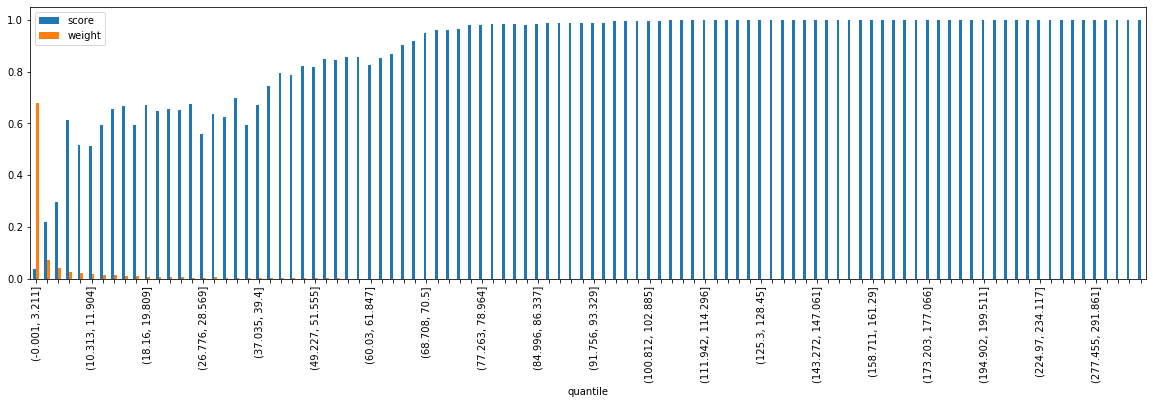

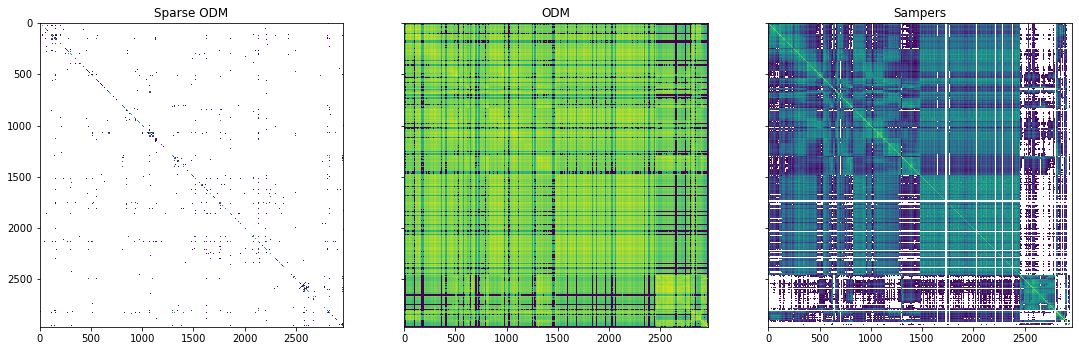

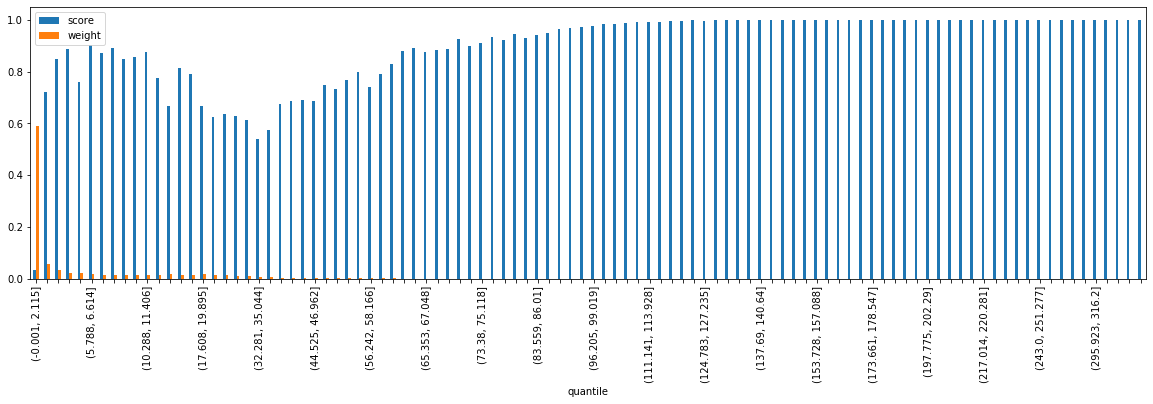

In [111]:
for scale in ['national', 'east', 'west']:
    print("Scale =", scale)
    odm, sparse_odm = val.validate(scale, visits, home_locations, gravity_beta=0.05)
    score = mscthesis.spssim(val.sampers_odm[scale], odm, val.sampers_distances[scale], nquantiles=100)
    validation_plots(odm, sparse_odm, val.sampers_odm[scale], score)
    print((score.score * score.weight).sum())
    print()

Scale = national
Not bboxing national
Aligning region-visits to Sampers zones...
removed 154224 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 12185 point-visits due to missing zone geom
1759991 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 1810 iterations
0.6184304023820449

Scale = east
removed 1009680 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 79346 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 5746 point-visits due to missing zone geom
831628 visits left after alignment
Creating ODM...
Gravity model...
IPF converged after 3690 iterations
0.1770754550654181

Scale = west
removed 1563520 visits due to sampling bbox
Aligning region-visits to Sampers zones...
removed 25844 region-visits due to missing zone geom
Aligning point-visits to Sampers zones...
removed 2096 point-visits due to missing zone geom
334940 visits left after align

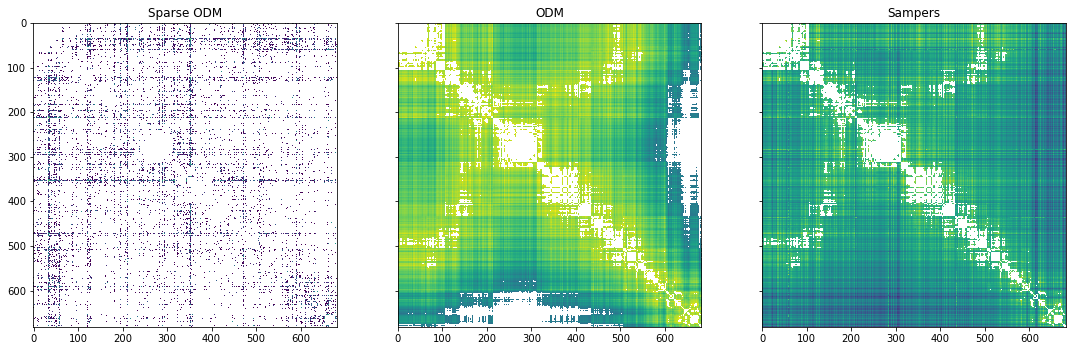

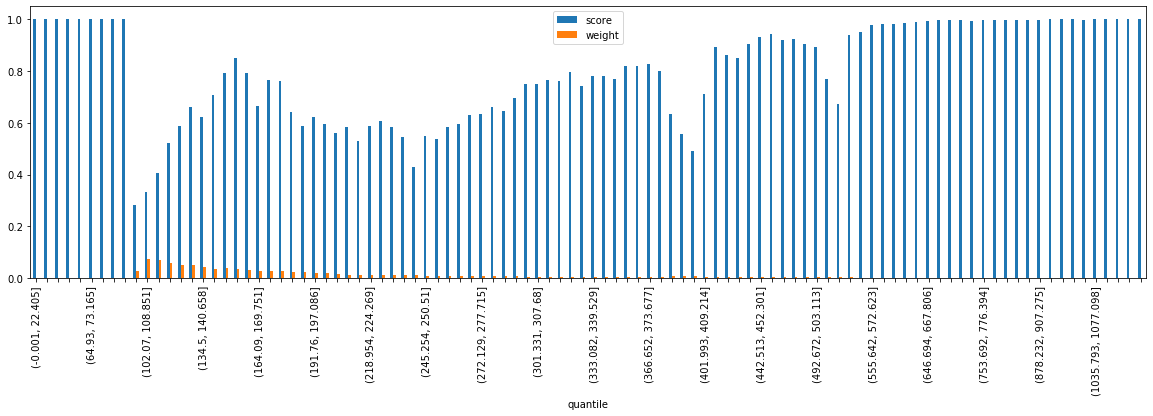

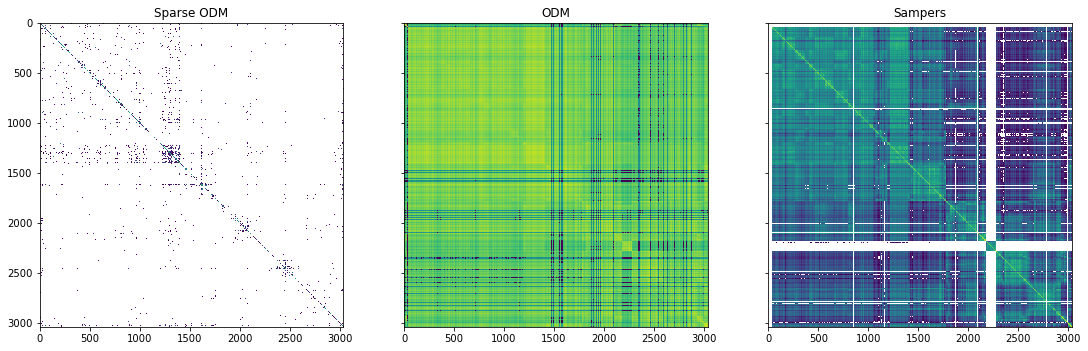

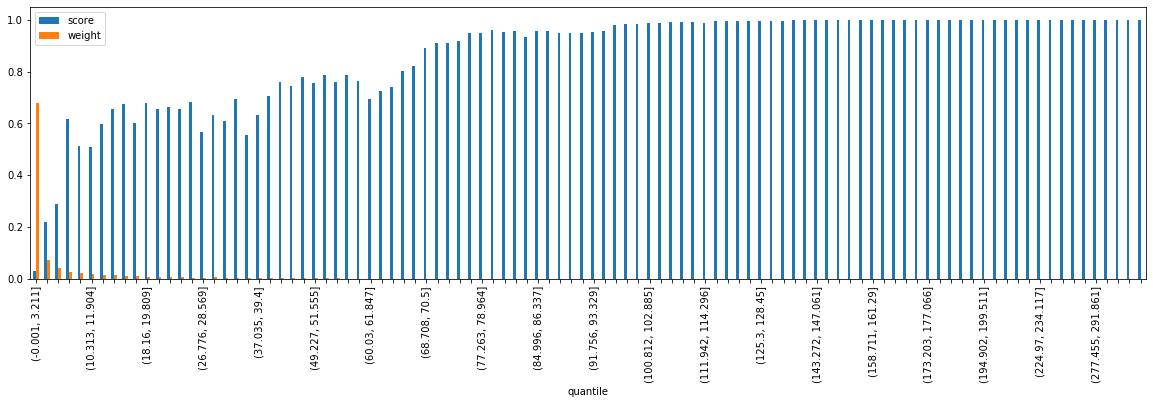

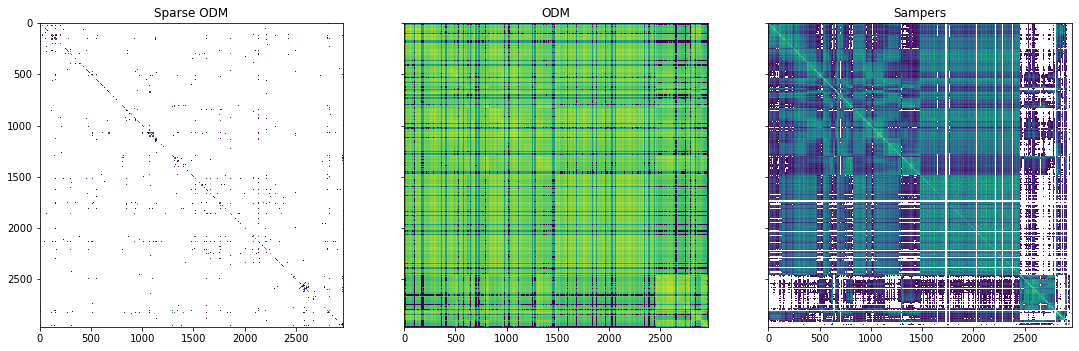

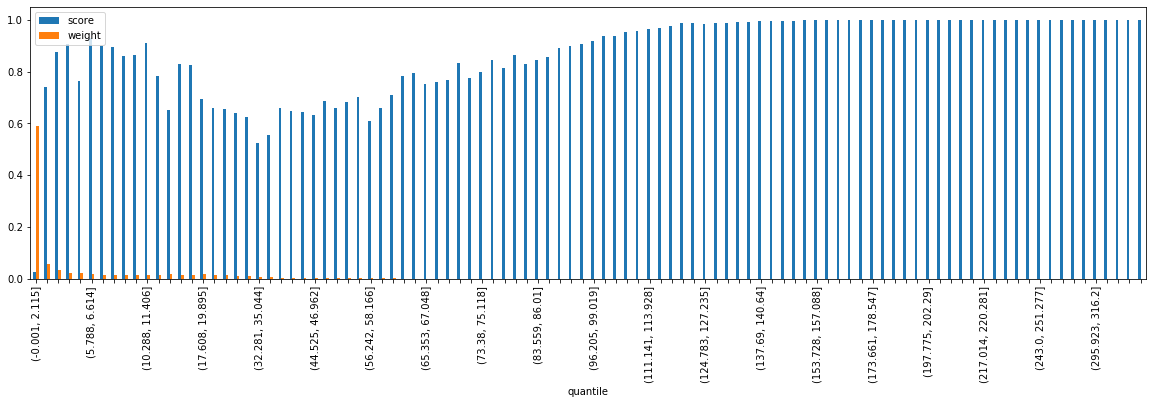

In [113]:
for scale in ['national', 'east', 'west']:
    print("Scale =", scale)
    odm, sparse_odm = val.validate(scale, visits, home_locations, gravity_beta=0.04)
    score = mscthesis.spssim(val.sampers_odm[scale], odm, val.sampers_distances[scale], nquantiles=100)
    validation_plots(odm, sparse_odm, val.sampers_odm[scale], score)
    print((score.score * score.weight).sum())
    print()

In [ ]:
def validation_plots(odm, sparse_odm, sampers_odm, score):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True)
    fig.set_size_inches(18.5, 10.5)
    ax1.set_title('Sparse ODM')
    ax1.imshow(sparse_odm.unstack().values, norm = mpl.colors.LogNorm())
    ax2.set_title('ODM')
    ax2.imshow(odm.unstack().values, norm = mpl.colors.LogNorm())
    ax3.set_title('Sampers')
    ax3.imshow(sampers_odm.unstack().values, norm = mpl.colors.LogNorm())
    
    fig, ax = plt.subplots(1,1, figsize=(20,5))
    score.plot(
        ax=ax,
        kind='bar',
        rot=90,
        fontsize=10,
    )
    for n, lbl in enumerate(ax.xaxis.get_ticklabels()):
        if n % 5 != 0:
            lbl.set_visible(False)

In [93]:
(score.score * score.weight).sum()

0.16682762521558958

In [23]:
visits

day  timeslot    kind  region   latitude  longitude
userid                                                                 
5616                  0         0  region       5  59.426889  17.954336
5616                  0         1  region       5  59.426889  17.954336
5616                  0         2  region     347  59.445959  17.942841
5616                  0         3  region       5  59.426889  17.954336
5616                  1         0  region       5  59.426889  17.954336
...                 ...       ...     ...     ...        ...        ...
794973407964229636  138         3  region       9  59.343052  18.051749
794973407964229636  139         0  region       0  59.314261  18.076535
794973407964229636  139         1  region      10  59.323559  18.096513
794973407964229636  139         2  region     110  59.391799  18.038725
794973407964229636  139         3  region       0  59.314261  18.076535

[1926400 rows x 6 columns]

### Remove users not in sampling zone

In [27]:
if sampers_scale in sampers.bbox:
    # Read home locations
    home_locations = pd.read_csv('./../../dbs/sweden/homelocations.csv').set_index('userid')
    home_locations = gpd.GeoDataFrame(
        home_locations,
        crs="EPSG:3006",
        geometry=gpd.points_from_xy(home_locations.x, home_locations.y),
    )
    # Remove home locations not in sampling zone
    print("Homelocations before filtering\t", home_locations.shape)
    home_locations = gpd.sjoin(home_locations, sampers.bbox[sampers_scale])
    print("Homelocations after filtering\t", home_locations.shape)
    # Remove users not in sampling zone
    print("Visits before filtering\t", visits.shape)
    visits = visits[visits.index.isin(home_locations.index)]
    print("Visits after filtering\t", visits.shape)
else:
    print("Not removing users due to no bounding box", sampers_scale)

Homelocations before filtering	 (4056, 3)
Homelocations after filtering	 (1951, 6)
Visits before filtering	 (1926400, 6)
Visits after filtering	 (916720, 6)


In [31]:
visits = gpd.GeoDataFrame(
    visits,
    crs="EPSG:4326",
    geometry=gpd.points_from_xy(visits.longitude, visits.latitude),
)
visits = visits.to_crs(sampers_zones.crs)
print("Visits\t", visits.shape)

Visits	 (916720, 7)


In [32]:
# Align regions to Sampers zones
regional_visits = visits[visits.kind == 'region']
print("Regional visits before align\t", regional_visits.shape)
user_regions = regional_visits.groupby(['userid', 'region']).head(1)
print("User regions before align\t", user_regions.shape)
user_zones = gpd.sjoin(user_regions, sampers_zones, op='intersects')[['region', 'zone']]
print("User zones after align\t\t", user_zones.shape)
regional_visitsx = user_zones.merge(regional_visits, on=['userid', 'region'])
print("Regional visits after align\t", regional_visitsx.shape)
print()
print("Regional visits lost during align\t", regional_visits.shape[0] - regional_visitsx.shape[0])

Regional visits before align	 (872440, 7)
User regions before align	 (91082, 7)
User zones after align		 (71301, 2)
Regional visits after align	 (793094, 8)

Regional visits lost during align	 79346


In [14]:
# Align points to Sampers zones
point_visits = visits[visits.kind == 'point']
print("Point visits before align\t", point_visits.shape)
point_visitsx = gpd.sjoin(point_visits, sampers_zones, op='intersects')
print("Point visits after align\t", point_visitsx.shape)
print()
print("Point visits lost during align\t", point_visits.shape[0] - point_visitsx.shape[0])

Point visits before align	 (44280, 7)
Point visits after align	 (38534, 12)

Point visits lost during align	 5746


In [15]:
# Recombine
visitsx = pd.concat([
    regional_visitsx[['day', 'timeslot', 'zone']],
    point_visitsx[['day', 'timeslot', 'zone']]
])
# Reorder based on index (userid, day, timeslot) to get visits in chonological order
visitsx = visitsx.reset_index().set_index(['userid', 'day', 'timeslot']).sort_index().reset_index().set_index('userid')
print("Visits after align\t", visitsx.shape)

Visits after align	 (831628, 3)


In [16]:
# Create ODM from visits
twitter_trips = mscthesis.visit_gaps(visitsx[['zone']])
twitter_odm = twitter_trips.groupby(['zone_origin', 'zone_destination']).size()
print("Twitter ODM before reindex\t", twitter_odm.shape)

# Reindex to Sampers ODM
twitter_odm = twitter_odm.reindex(sampers_odm.index, fill_value=0)
print("Twitter ODM after reindex\t", twitter_odm.shape)

# Normalize
twitter_odm = twitter_odm / twitter_odm.sum()

Twitter ODM before reindex	 (144005,)
Twitter ODM after reindex	 (9229444,)


In [17]:
# Remove trips shorter than 100km if national scale...
if sampers_scale == 'national':
    twitter_odm[distancesx < 100] = 0
    sampers_odm[distancesx < 100] = 0
    # ...and normalize again
    sampers_odm = sampers_odm / sampers_odm.sum()
    twitter_odm = twitter_odm / twitter_odm.sum()

# Visual comparison

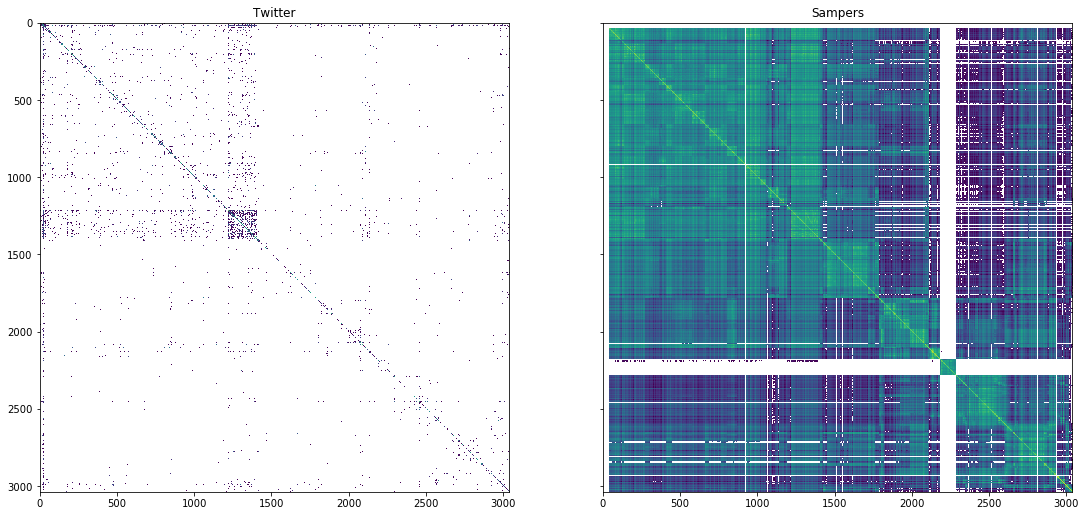

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
ax1.imshow(twitter_odm.unstack().values, norm = mpl.colors.LogNorm())
ax2.imshow(sampers_odm.unstack().values, norm = mpl.colors.LogNorm())
ax1.set_title('Twitter')
ax2.set_title('Sampers')
plt.show()

In [94]:
score = mscthesis.spssim(sampers_odm, twitter_odm, distancesx, nquantiles=100)

NameError: name 'twitter_odm' is not defined

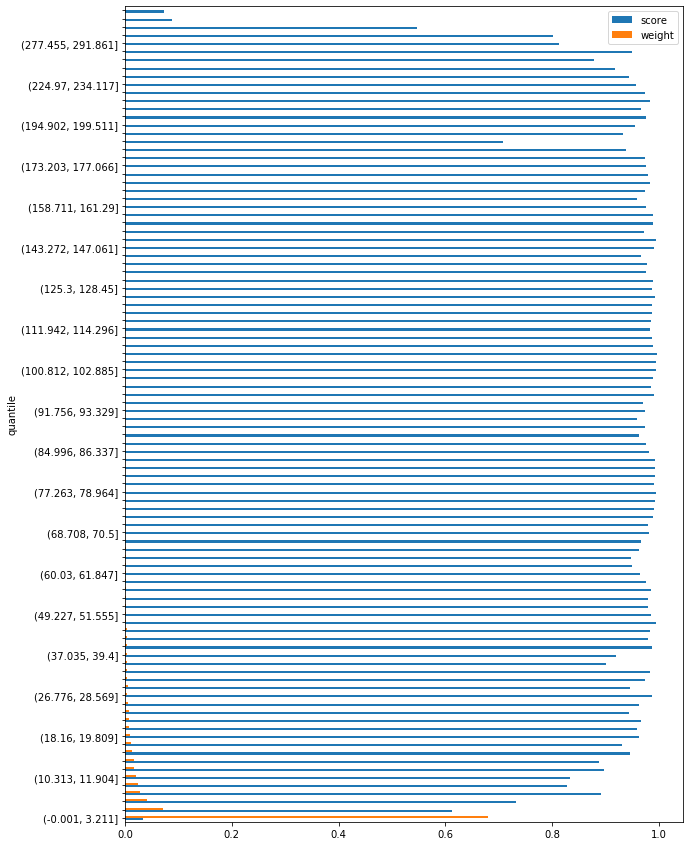

In [20]:
ax = score.plot(
    kind='barh', 
    figsize=(10,15), 
    rot=0,
    fontsize=10,
)
for n, lbl in enumerate(ax.yaxis.get_ticklabels()):
    if n % 5 != 0:
        lbl.set_visible(False)

In [21]:
score.describe()

score        weight
count  100.000000  1.000000e+02
mean     0.924079  1.000000e-02
std      0.169208  6.834068e-02
min      0.033896  3.211192e-13
25%      0.947205  1.083054e-05
50%      0.975683  1.140110e-04
75%      0.987095  1.811451e-03
max      0.996370  6.803014e-01

In [24]:
(score.score * score.weight).sum()

0.28619616828815064